<a href="https://colab.research.google.com/github/Unfeir/DS/blob/main/hw_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name='weights')
        self.b = tf.Variable(tf.zeros([out_features]), name='bias')

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        if self.name in['dense_layer_1', 'dense_layer_2']:
          return tf.nn.sigmoid(y)
        else:
          return tf.nn.softmax(y)



class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, name='dense_layer_1')
    # Второй слой, состоящий из 256 нейронов
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, name='dense_layer_2')
    # Выходной слой
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=10, name='output_layer')


  def __call__(self, x):
    # Место для вашего кода
    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    # Прогонемо через слої нашої мережі
    x1 = self.layer1(x)
    x2 = self.layer2(x1)
    x3 = self.output_layer(x2)

    # Для выхода нейронной сети применяем функцию softmax
    return x3

In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    # переведемо верогідності у індекси класів, порівняємо результати ти вирахуємо середню
    y_pred_labels = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_labels, y_true)

    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy


In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = nn.trainable_variables
    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
  # Convert batch_y to int64 data type
    batch_y = tf.cast(batch_y, tf.int64)
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)
    # Место для вашего кода

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Место для вашего кода
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)

        print(f"{step=} | {current_loss=:.4f} | {current_accuracy=:.4f}")

step=100 | current_loss=357.0862 | current_accuracy=0.6523
step=200 | current_loss=233.9367 | current_accuracy=0.7617
step=300 | current_loss=142.7480 | current_accuracy=0.8281
step=400 | current_loss=199.5658 | current_accuracy=0.8242
step=500 | current_loss=137.2990 | current_accuracy=0.8398
step=600 | current_loss=128.0391 | current_accuracy=0.8398
step=700 | current_loss=93.0859 | current_accuracy=0.8828
step=800 | current_loss=125.1261 | current_accuracy=0.8477
step=900 | current_loss=107.5053 | current_accuracy=0.8828
step=1000 | current_loss=93.7434 | current_accuracy=0.8828
step=1100 | current_loss=114.3121 | current_accuracy=0.8633
step=1200 | current_loss=81.3820 | current_accuracy=0.8906
step=1300 | current_loss=100.2562 | current_accuracy=0.8750
step=1400 | current_loss=126.8824 | current_accuracy=0.8750
step=1500 | current_loss=86.2128 | current_accuracy=0.9219
step=1600 | current_loss=89.1109 | current_accuracy=0.9102
step=1700 | current_loss=57.7729 | current_accuracy=0.

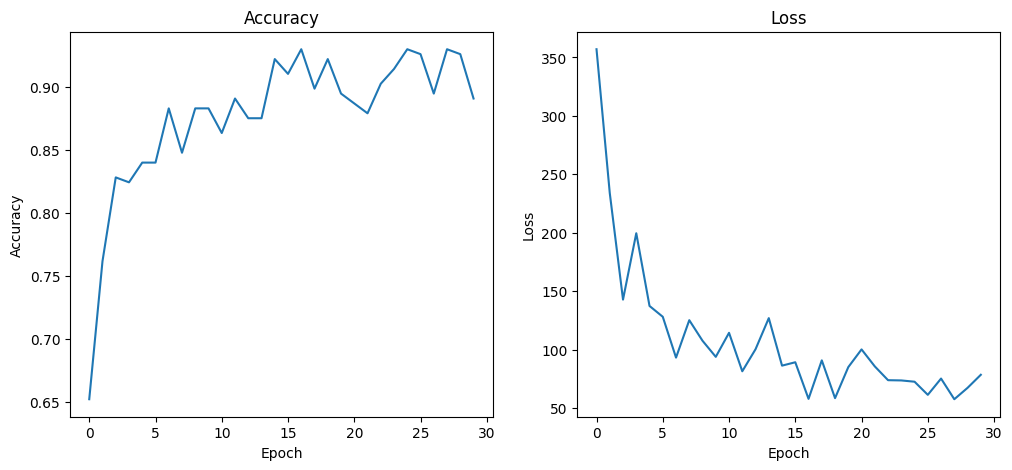

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(accuracy_history)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')

plt.show()

In [15]:
# Вычислите точность обученной нейросети

predict = neural_net(x_test)
m = tf.keras.metrics.Accuracy()
m.update_state(y_test, tf.math.argmax(predict, axis=1))
m.result().numpy()

0.9032

In [21]:
from PIL import Image
import random

random_choice = random.sample(range(len(x_test)), 5)


predict = neural_net(x_test[random_choice])
predict_values = tf.argmax(predict, axis=1)


for el in range(len(x_test[random_choice])):


    img = Image.fromarray((x_test[random_choice][el].reshape((28, 28)) *512).astype(np.uint8))
    display(img)

    predict_value = predict_values[el]
    print(f'response: {predict_values[el]}\n\n')


response: 0




response: 0




response: 6




response: 4




response: 2




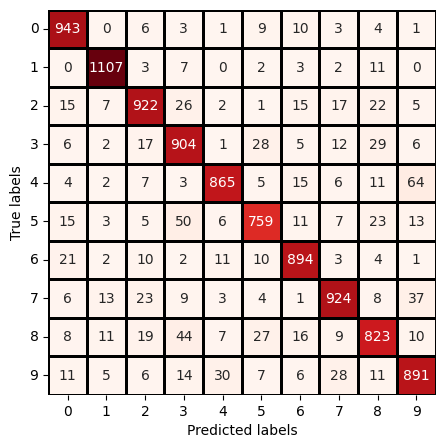

In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn



random_choice = random.sample(range(len(x_test)), 10000)
test_images = x_test[random_choice]
test_values = y_test[random_choice]
predict = neural_net(x_test[random_choice])
predict_values = tf.argmax(predict, axis=1)
unique_labels = np.unique(np.concatenate([y_test[random_choice], predict_values]))
cm = confusion_matrix(y_test[random_choice], predict_values, labels=unique_labels)
df_confusion_matrix = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
plt.figure(figsize=(5,5))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Reds", linewidths=1, linecolor="black")
plt.xlabel("Predicted labels", fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel("True labels", fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.show()

# Висновок

Точність станоить 0.9032. Як можна побачити під час навчання варюється від 0.88 до 0.93
Найбільші похибки в моделі між парами цифр (5, 3), (8, 3), (4, 9)